Imports

In [2]:
#import 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

Get data into df

In [3]:
df = pd.read_csv('./data/kc_house_data.csv',
                parse_dates=['date'])
df1 = df.copy()
df2 = df.copy()

In [4]:
pd.set_option('display.max_colwidth', None) #allows us to see the full text of each object column, namely the "address" field
# df.head()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             30155 non-null  int64         
 1   date           30155 non-null  datetime64[ns]
 2   price          30155 non-null  float64       
 3   bedrooms       30155 non-null  int64         
 4   bathrooms      30155 non-null  float64       
 5   sqft_living    30155 non-null  int64         
 6   sqft_lot       30155 non-null  int64         
 7   floors         30155 non-null  float64       
 8   waterfront     30155 non-null  object        
 9   greenbelt      30155 non-null  object        
 10  nuisance       30155 non-null  object        
 11  view           30155 non-null  object        
 12  condition      30155 non-null  object        
 13  grade          30155 non-null  object        
 14  heat_source    30123 non-null  object        
 15  sewer_system   3014

#### Prices

Text(0, 0.5, 'Number of houses')

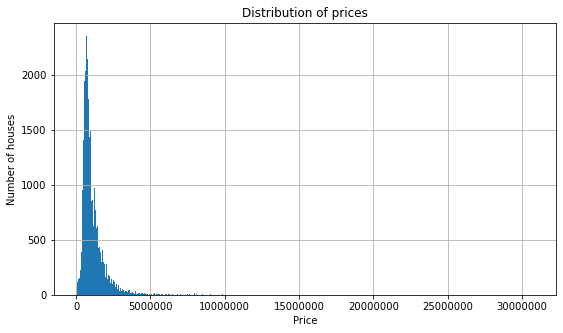

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))
df['price'].hist(bins=500, ax=ax)
ax.ticklabel_format(style='plain')
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('Number of houses')

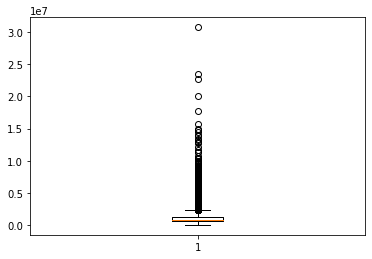

In [7]:
plt.boxplot(df['price']);

The prices appear to be fairly normally distributed, but with a long maximum tail.
Could look at as log, but will instead chop off houses with prices above 5mil, as
"our stakeholders aren't looking to spend that much money". Will chop off above 3*std and re-examine.

In [8]:
df['price'].describe()

count    3.015500e+04
mean     1.108536e+06
std      8.963857e+05
min      2.736000e+04
25%      6.480000e+05
50%      8.600000e+05
75%      1.300000e+06
max      3.075000e+07
Name: price, dtype: float64

In [9]:
df_clean = df.loc[df['price']<5000000]

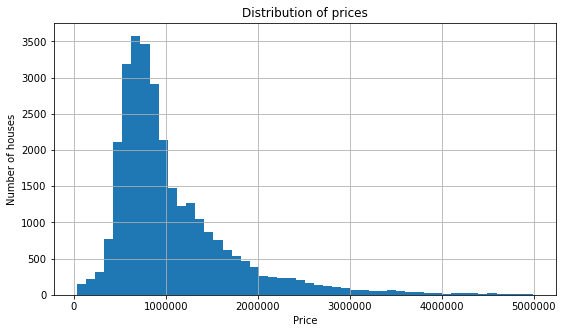

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))
df_clean['price'].hist(bins=50, ax=ax)
ax.ticklabel_format(style='plain')
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('Number of houses');

In [11]:
df_clean['price'].describe()

count    2.994000e+04
mean     1.062370e+06
std      6.572221e+05
min      2.736000e+04
25%      6.450000e+05
50%      8.575000e+05
75%      1.299962e+06
max      4.995000e+06
Name: price, dtype: float64

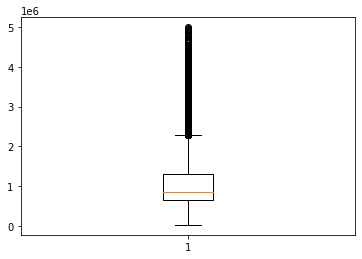

In [12]:
plt.boxplot(df_clean['price']);

Even after chopping off prices above 5mil, there are still a lot of outliers, as defined by the IQR. We will remove these outliers and then re-examine.

In [13]:
# IQR
Q1 = np.percentile(df_clean['price'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df_clean['price'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

In [14]:
# Upper bound
upper_limit = Q3 + 1.5 * IQR
upper_limit

2282436.25

According to IQR, which we're using here since the dataset is skewed, values above 2.28 mil are outliers. We'll trim these off.

In [15]:
# Trim
df_clean = df_clean[df_clean['price'] < upper_limit]

Now that we have trimmed off these outliers, we'll re-examine the dataset.

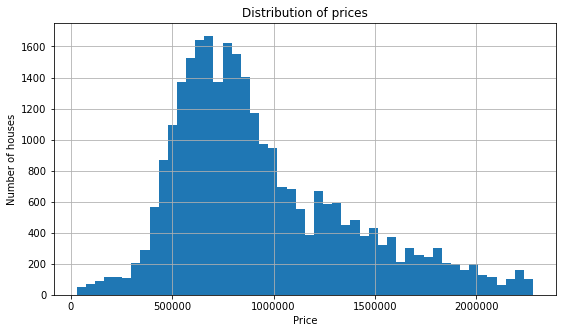

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))
df_clean['price'].hist(bins=50, ax=ax)
ax.ticklabel_format(style='plain')
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('Number of houses');

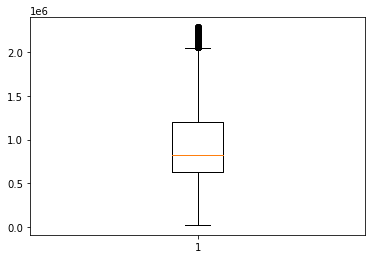

In [17]:
plt.boxplot(df_clean['price']);

In [18]:
df_clean['price'].describe()

count    2.816500e+04
mean     9.417486e+05
std      4.351478e+05
min      2.736000e+04
25%      6.300000e+05
50%      8.299500e+05
75%      1.199000e+06
max      2.281000e+06
Name: price, dtype: float64

In [19]:
stats.skewtest(df_clean['price'], axis=0, nan_policy='raise')

SkewtestResult(statistic=53.48353519446607, pvalue=0.0)

After some additional research, it looks like the independent and dependent variables don't need to have a good normal distribution to work on, only the errors need to be normally distributed. With this in mind we can go ahead to the next variable.

In [20]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28165 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             28165 non-null  int64         
 1   date           28165 non-null  datetime64[ns]
 2   price          28165 non-null  float64       
 3   bedrooms       28165 non-null  int64         
 4   bathrooms      28165 non-null  float64       
 5   sqft_living    28165 non-null  int64         
 6   sqft_lot       28165 non-null  int64         
 7   floors         28165 non-null  float64       
 8   waterfront     28165 non-null  object        
 9   greenbelt      28165 non-null  object        
 10  nuisance       28165 non-null  object        
 11  view           28165 non-null  object        
 12  condition      28165 non-null  object        
 13  grade          28165 non-null  object        
 14  heat_source    28134 non-null  object        
 15  sewer_system   2815

In [21]:
df_clean['bedrooms'].value_counts()

3     12422
4      8735
2      3886
5      2215
6       384
1       371
7        62
0        40
8        33
9        13
10        3
11        1
Name: bedrooms, dtype: int64

0 bedroom = studio
11 bedroom?? sure I guess. These seem ok.

In [22]:
df_clean['bathrooms'].value_counts()

2.5    8175
2.0    7237
1.0    4527
3.0    3836
1.5    1784
3.5    1776
4.0     464
4.5     216
5.0      52
5.5      31
0.0      30
6.0      19
6.5       5
0.5       5
7.0       4
7.5       4
Name: bathrooms, dtype: int64

There is no way these homes have 0 bathrooms. Changing the 0's to 1's. Rounding 0.5's up as these are quasi-categorical.(2x 0.5bath != 1bath. 1x 1bath = 2bath.)

In [23]:
df_clean.loc[df_clean['bathrooms'] == 0, 'bathrooms'] = 1
df_clean['bathrooms'] = df_clean['bathrooms'].apply(np.ceil)

Drop unnecessary columns:

In [24]:
df_clean.drop(['id', 'date', 'sqft_lot', 'floors'], axis=1, inplace=True)

In [25]:
df_clean['bathrooms'].value_counts()

3.0    12011
2.0     9021
1.0     4562
4.0     2240
5.0      268
6.0       50
7.0        9
8.0        4
Name: bathrooms, dtype: int64

Try log of price again, to see if it looks more normal.

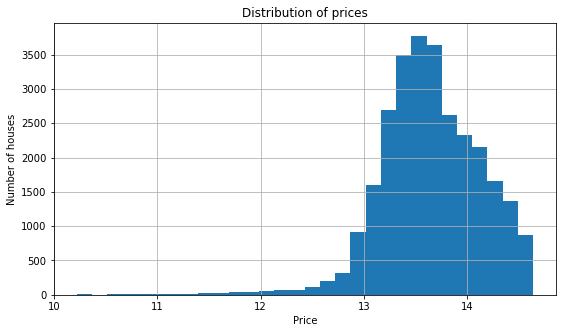

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))
np.log(df_clean['price']).hist(bins=30, ax=ax)
ax.ticklabel_format(style='plain')
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('Number of houses');

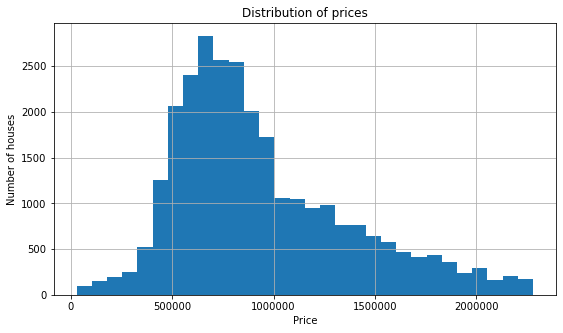

In [27]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))
df_clean['price'].hist(bins=30, ax=ax)
ax.ticklabel_format(style='plain')
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('Number of houses');

In [28]:
df_clean['view'].value_counts()

NONE         25359
AVERAGE       1670
GOOD           681
EXCELLENT      279
FAIR           176
Name: view, dtype: int64

### Cleaning data from others in group:

In [29]:
# Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom). Change 0 bathroom to 1 bathroom. Round up other values.
df.loc[df['bathrooms'] == 0, 'bathrooms'] = 1
df['bathrooms'] = df['bathrooms'].apply(np.ceil)
# Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom). Change 0 bathroom to 1 bathroom. Round up other values.
df.loc[df['bathrooms'] == 0, 'bathrooms'] = 1
df['bathrooms'] = df['bathrooms'].apply(np.ceil)



# Create binary substitutes for columns
df['basement_binary'] = [1 if sq >  0  else 0 for sq in df['sqft_basement']]
df['garage_binary'] = [1 if sq >  0  else 0 for sq in df['sqft_garage']]
df['patio_binary'] = [1 if sq >  0  else 0 for sq in df['sqft_patio']]
df['waterfront_binary'] = [1 if sq == 'YES'  else 0 for sq in df['waterfront']]
df['PublicSewer_binary'] = [1 if sq == 'PUBLIC' else 0 for sq in df['sewer_system']]

# Create zip from address
df['zip'] = [x.split(',')[2][-5:] for x in df['address']] 

# Create 'total_sqft' by combining sqft_above + sqft_basement + 
# sqft_garage + sqft_patio
df['total_sqft'] = df['sqft_above'] + df['sqft_basement'] + df['sqft_garage'] +
                    df['sqft_patio']

# Create binary values for greenbelt, nuisance
# Using OneHotEncoder

greenbelt_cat = df[['greenbelt']]
encoder_greenbelt = OrdinalEncoder()
encoder_greenbelt.fit(greenbelt_cat)
encoder_greenbelt.categories_[0]
greenbelt_encoded_train = encoder_greenbelt.transform(greenbelt_cat)
greenbelt_encoded_train = greenbelt_encoded_train.flatten()
# greenbelt_encoded_train
df["greenbelt"] = greenbelt_encoded_train

nuisance_cat = df[['nuisance']]
encoder_nuisance = OrdinalEncoder()
encoder_nuisance.fit(nuisance_cat)
encoder_nuisance.categories_[0]
nuisance_encoded_train = encoder_nuisance.transform(nuisance_cat)
nuisance_encoded_train = nuisance_encoded_train.flatten()
df["nuisance"] = nuisance_encoded_train

# Create Ordinal Values for condition
# Using OneHotEncoder
condition_cat = df[['condition']]
condition_categories = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
encoder_condition = OrdinalEncoder(categories=[condition_categories])
encoder_condition.fit(condition_cat)
condition_encoded_train = encoder_condition.transform(condition_cat)
condition_encoded_train = condition_encoded_train.flatten()
df["condition"] = condition_encoded_train

# Create Ordinal Values for view
# Using OneHotEncoder
view_cat = df[['view']]
view_categories = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
encoder_view = OrdinalEncoder(categories=[view_categories])
encoder_view.fit(view_cat)
encoder_view.categories_[0]
view_encoded_train = encoder_view.transform(view_cat)
view_encoded_train = view_encoded_train.flatten()
df["view"] = view_encoded_train

# #https://www.zillow.com/browse/homes/wa/king-county/  - remove all records with zipcodes that dont start with '98'
# df = df[df.zip.str.startswith(('98'))]

# # (1) Create a variable zip
# # extracted from df
# # (double brackets due to shape expected by OHE)
# fireplace_qu_train = df[["zip"]]

# # (2) Instantiate a OneHotEncoder with categories="auto",
# # sparse=False, and handle_unknown="ignore"
# ohe = OneHotEncoder(categories="auto",
#                     sparse=False,
#                     handle_unknown="ignore")

# # (3) Fit the encoder on fireplace_qu_train
# ohe.fit(fireplace_qu_train)

# # Inspect the categories of the fitted encoder
# ohe.categories_

# # Replace None with appropriate code

# # (4) Transform fireplace_qu_train using the encoder and
# # assign the result to fireplace_qu_encoded_train
# fireplace_qu_encoded_train = ohe.transform(fireplace_qu_train)

# # Visually inspect fireplace_qu_encoded_train
# fireplace_qu_encoded_train

# # Run this cell without changes

# # (5a) Make the transformed data into a dataframe
# fireplace_qu_encoded_train = pd.DataFrame(
#     # Pass in NumPy array
#     fireplace_qu_encoded_train,
#     # Set the column names to the categories found by OHE
#     columns=ohe.categories_[0],
#     # Set the index to match X_train's index
#     index=df.index
# )

# # Visually inspect new dataframe
# fireplace_qu_encoded_train

# # Run this cell without changes

# # (5b) Drop original FireplaceQu column
# df.drop("zip", axis=1, inplace=True)

# # Visually inspect X_train
# df

# # Run this cell without changes

# # (5c) Concatenate the new dataframe with current X_train
# df = pd.concat([df, fireplace_qu_encoded_train], axis=1)

# # Visually inspect X_train
# df.head()


# Drop unnecessary columns
df.drop(['id', 'date', 'sqft_lot', 'floors', 'grade',
         'heat_source','sqft_above','lat','long'], axis=1, inplace=True)


SyntaxError: invalid syntax (<ipython-input-29-4bd471646702>, line 22)

In [ ]:
df_poor = df[df['price'] < 1000000]
df_poor

In [ ]:
X = df_poor.drop(columns=['price', 'sewer_system', 'waterfront','address','sqft_patio', 'sqft_basement', 'sqft_garage','bedrooms', 'bathrooms','PublicSewer_binary','garage_binary'])
y = df_poor['price']


In [ ]:
results_full = sm.OLS(y, sm.add_constant(X)).fit()
results_full.summary()

In [ ]:
df_rich = df[df['price'] >= 1000000]
df_rich

In [ ]:
X = df_rich.drop(columns=['price', 'sewer_system', 'waterfront','address','sqft_patio', 'sqft_basement', 'sqft_garage','bedrooms', 'bathrooms','PublicSewer_binary','garage_binary'])
y = df_rich['price']


In [ ]:
results_full = sm.OLS(y, sm.add_constant(X)).fit()
results_full.summary()

In [ ]:
df.info()

In [ ]:
# df_poor = df[df['price'] < 1000000]

X = df.drop(columns=['price', 'sewer_system', 'waterfront',
                     'address','sqft_patio', 'sqft_basement',
                     'sqft_garage','bedrooms', 'bathrooms',
                     'PublicSewer_binary','garage_binary',
                     'view', 'sqft_basement', 'yr_renovated',
                    'address', 'zip', 'condition'])
y = df['price']

In [ ]:
results_full = sm.OLS(y, sm.add_constant(X)).fit()
results_full.summary()

In [ ]:
# Cleaning for df2

# Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom). Change 0 bathroom to 1 bathroom. Round up other values.
df2.loc[df['bathrooms'] == 0, 'bathrooms'] = 1
df2['bathrooms'] = df2['bathrooms'].apply(np.ceil)
# Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom). Change 0 bathroom to 1 bathroom. Round up other values.
df2.loc[df['bathrooms'] == 0, 'bathrooms'] = 1
df2['bathrooms'] = df['bathrooms'].apply(np.ceil)



# Create binary substitutes for columns
df2['basement_binary'] = [1 if sq >  0  else 0 for sq in df['sqft_basement']]
df2['garage_binary'] = [1 if sq >  0  else 0 for sq in df['sqft_garage']]
df2['patio_binary'] = [1 if sq >  0  else 0 for sq in df['sqft_patio']]
df2['waterfront_binary'] = [1 if sq == 'YES'  else 0 for sq in df['waterfront']]
df2['PublicSewer_binary'] = [1 if sq == 'PUBLIC' else 0 for sq in df['sewer_system']]

# Create zip from address
df2['zip'] = [x.split(',')[2][-5:] for x in df2['address']] 

# Create 'total_sqft' by combining sqft_above + sqft_basement + 
# sqft_garage + sqft_patio
df2['total_sqft'] = df2['sqft_above'] + df2['sqft_basement'] + df2['sqft_garage'] + df2['sqft_patio']

# Create binary values for greenbelt, nuisance
# Using OneHotEncoder

greenbelt_cat = df2[['greenbelt']]
encoder_greenbelt = OrdinalEncoder()
encoder_greenbelt.fit(greenbelt_cat)
encoder_greenbelt.categories_[0]
greenbelt_encoded_train = encoder_greenbelt.transform(greenbelt_cat)
greenbelt_encoded_train = greenbelt_encoded_train.flatten()
# greenbelt_encoded_train
df2["greenbelt"] = greenbelt_encoded_train

nuisance_cat = df2[['nuisance']]
encoder_nuisance = OrdinalEncoder()
encoder_nuisance.fit(nuisance_cat)
encoder_nuisance.categories_[0]
nuisance_encoded_train = encoder_nuisance.transform(nuisance_cat)
nuisance_encoded_train = nuisance_encoded_train.flatten()
df2["nuisance"] = nuisance_encoded_train

# Create Ordinal Values for condition
# Using OneHotEncoder
condition_cat = df2[['condition']]
condition_categories = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
encoder_condition = OrdinalEncoder(categories=[condition_categories])
encoder_condition.fit(condition_cat)
condition_encoded_train = encoder_condition.transform(condition_cat)
condition_encoded_train = condition_encoded_train.flatten()
df2["condition"] = condition_encoded_train

# Create Ordinal Values for view
# Using OneHotEncoder
view_cat = df2[['view']]
view_categories = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
encoder_view = OrdinalEncoder(categories=[view_categories])
encoder_view.fit(view_cat)
encoder_view.categories_[0]
view_encoded_train = encoder_view.transform(view_cat)
view_encoded_train = view_encoded_train.flatten()
df2["view"] = view_encoded_train

# #https://www.zillow.com/browse/homes/wa/king-county/  - remove all records with zipcodes that dont start with '98'
# df2 = df2[df2.zip.str.startswith(('98'))]

# # (1) Create a variable zip
# # extracted from df2
# # (double brackets due to shape expected by OHE)
# fireplace_qu_train = df2[["zip"]]

# # (2) Instantiate a OneHotEncoder with categories="auto",
# # sparse=False, and handle_unknown="ignore"
# ohe = OneHotEncoder(categories="auto",
#                     sparse=False,
#                     handle_unknown="ignore")

# # (3) Fit the encoder on fireplace_qu_train
# ohe.fit(fireplace_qu_train)

# # Inspect the categories of the fitted encoder
# ohe.categories_

# # Replace None with appropriate code

# # (4) Transform fireplace_qu_train using the encoder and
# # assign the result to fireplace_qu_encoded_train
# fireplace_qu_encoded_train = ohe.transform(fireplace_qu_train)

# # Visually inspect fireplace_qu_encoded_train
# fireplace_qu_encoded_train

# # Run this cell without changes

# # (5a) Make the transformed data into a dataframe
# fireplace_qu_encoded_train = pd.DataFrame(
#     # Pass in NumPy array
#     fireplace_qu_encoded_train,
#     # Set the column names to the categories found by OHE
#     columns=ohe.categories_[0],
#     # Set the index to match X_train's index
#     index=df2.index
# )

# # Visually inspect new dataframe
# fireplace_qu_encoded_train

# # Run this cell without changes

# # (5b) Drop original FireplaceQu column
# df2.drop("zip", axis=1, inplace=True)

# # Visually inspect X_train
# df2

# # Run this cell without changes

# # (5c) Concatenate the new dataframe with current X_train
# df2 = pd.concat([df2, fireplace_qu_encoded_train], axis=1)

# # Visually inspect X_train
# df2.head()


# Drop unnecessary columns
df2.drop(['id', 'date', 'sqft_lot', 'grade',
         'heat_source','sqft_above','lat','long'], axis=1, inplace=True)
# 'floors',

In [ ]:
X = df2.drop(columns=['price', 'sewer_system', 'waterfront',
                     'address','sqft_patio', 'sqft_basement',
                     'sqft_garage','bedrooms', 'bathrooms',
                     'PublicSewer_binary','garage_binary',
                     'view', 'sqft_basement', 'yr_renovated',
                    'address', 'zip', 'condition', 'floors'])
y = df2['price']

results_full = sm.OLS(y, sm.add_constant(X)).fit()
results_full.summary()

### 4 Assumptions of Linear Regression

(i) linearity and additivity of the relationship between dependent and independent variables:

    (a) The expected value of dependent variable is a straight-line function of each independent variable, holding the others fixed.

    (b) The slope of that line does not depend on the values of the other variables.

    (c)  The effects of different independent variables on the expected value of the dependent variable are additive.

(ii) statistical independence of the errors (in particular, no correlation between consecutive errors in the case of time series data)

(iii) homoscedasticity (constant variance) of the errors

    (a) versus time (in the case of time series data)

    (b) versus the predictions

    (c) versus any independent variable

(iv) normality of the error distribution.

In [84]:
df = pd.read_csv('./data/kc_house_data.csv',
                parse_dates=['date'])

df.drop(['id', 'floors',
         'heat_source','lat','long'], axis=1, inplace=True)

# Create zip from address
df['zip'] = [x.split(',')[2][-5:] for x in df['address']] 

#https://www.zillow.com/browse/homes/wa/king-county/  - remove all records with zipcodes that dont start with '98'
df = df[df.zip.str.startswith(('98'))]

df['city'] = [x.split(',')[1][0:] for x in df['address']]

df['city'].value_counts()

#create sale year column from datetime date info
df['sale_year'] = pd.DatetimeIndex(df['date']).year.astype(int)

df['sale_year'].value_counts()


#create new column - age of house
df['home_age'] = (df['sale_year']+1) - df['yr_built']

#create new column - time since reno
df['yr_from_reno'] = (df['sale_year']+1) - df['yr_renovated']

# create filter for yr_from_reno to ID houses that haven't been renovated
reno_filter = df['yr_from_reno'] > 2000

# create new column for design_age to see time since build if no reno, or time since reno if renovated
# first set to reno age
df['design_age'] = df['yr_from_reno']
#then update columns where there was no reno to age of the home
df['design_age'].loc[reno_filter] = df['home_age']

#some houses were sold before they were built - we need to change those records to 0

prebuild_filter = df['design_age'] < 1

df['design_age'].loc[prebuild_filter] = 1


y = df["price"]
X = df.drop("price", axis=1)

X_train = df

C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [85]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)
X_train = df

print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

from sklearn.linear_model import LinearRegression

model = LinearRegression()

## Building Training Transformations

df.grade.value_counts()

# Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom). Change 0 bathroom to 1 bathroom. Round up other values.
X_train.loc[df['bathrooms'] == 0, 'bathrooms'] = 1
X_train['bathrooms'] = X_train['bathrooms'].apply(np.ceil)


# Create binary substitutes for columns
X_train['basement_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_basement']]
X_train['garage_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_garage']]
X_train['patio_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_patio']]
X_train['waterfront_binary'] = [1 if sq == 'YES'  else 0 for sq in X_train['waterfront']]
X_train['PublicSewer_binary'] = [1 if sq == 'PUBLIC' else 0 for sq in X_train['sewer_system']]
X_train['yrenovated_binary'] = [1 if sq >  0 else 0 for sq in X_train['yr_renovated']]


# Create binary values for greenbelt, nuisance
# Using OneHotEncoder

greenbelt_cat = X_train[['greenbelt']]
encoder_greenbelt = OrdinalEncoder(categories=[['NO', 'YES']])
encoder_greenbelt.fit(greenbelt_cat)
greenbelt_encoded_train = encoder_greenbelt.transform(greenbelt_cat)
greenbelt_encoded_train = greenbelt_encoded_train.flatten()
# greenbelt_encoded_train
X_train["greenbelt"] = greenbelt_encoded_train

nuisance_cat = X_train[['nuisance']]
encoder_nuisance = OrdinalEncoder()
encoder_nuisance.fit(nuisance_cat)
nuisance_encoded_train = encoder_nuisance.transform(nuisance_cat)
nuisance_encoded_train = nuisance_encoded_train.flatten()
X_train["nuisance"] = nuisance_encoded_train

# Create Ordinal Values for condition
# Using OneHotEncoder
condition_cat = X_train[['condition']]
condition_categories = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
encoder_condition = OrdinalEncoder(categories=[condition_categories])
encoder_condition.fit(condition_cat)
condition_encoded_train = encoder_condition.transform(condition_cat)
condition_encoded_train = condition_encoded_train.flatten()
X_train["condition"] = condition_encoded_train

# Create Ordinal Values for view
# Using OneHotEncoder
view_cat = X_train[['view']]
view_categories = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
encoder_view = OrdinalEncoder(categories=[view_categories])
encoder_view.fit(view_cat)
view_encoded_train = encoder_view.transform(view_cat)
view_encoded_train = view_encoded_train.flatten()
X_train["view"] = view_encoded_train


grade_cat = X_train[['grade']]
grade_categories = ['1 Cabin', '2 Substandard', '3 Poor', '4 Low', '5 Fair', '6 Low Average',
                    '7 Average', '8 Good', '9 Better', '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion']
encoder_grade = OrdinalEncoder(categories=[grade_categories])
encoder_grade.fit(grade_cat)
grade_encoded_train = encoder_grade.transform(grade_cat)
grade_encoded_train = grade_encoded_train.flatten()
X_train["grade"] = grade_encoded_train

# (1) Create a variable zip
# extracted from df
# (double brackets due to shape expected by OHE)
fireplace_qu_train = X_train[["city"]]

ohe = OneHotEncoder(categories="auto",
                    sparse=False,
                    handle_unknown="ignore")

# (3) Fit the encoder on fireplace_qu_train
ohe.fit(fireplace_qu_train)

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
fireplace_qu_encoded_train = ohe.transform(fireplace_qu_train)

# Replace None with appropriate code

# (4) Transform fireplace_qu_train using the encoder and
# assign the result to fireplace_qu_encoded_train
fireplace_qu_encoded_train = ohe.transform(fireplace_qu_train)

# Visually inspect fireplace_qu_encoded_train
fireplace_qu_encoded_train

# (5a) Make the transformed data into a dataframe
fireplace_qu_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    fireplace_qu_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_test's index
    index=X_train.index
)

# Run this cell without changes

# (5b) Drop original FireplaceQu column
X_train.drop("city", axis=1, inplace=True)

# Run this cell without changes

# (5c) Concatenate the new dataframe with current X_train
X_train = pd.concat([X_train, fireplace_qu_encoded_train], axis=1)

# Visually inspect X_train
X_train.head()

# (1) Create a variable zip
# extracted from df
# (double brackets due to shape expected by OHE)
fireplace_qu_train = X_train[["zip"]]

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe = OneHotEncoder(categories="auto",
                    sparse=False,
                    handle_unknown="ignore")

# (3) Fit the encoder on fireplace_qu_train
ohe.fit(fireplace_qu_train)

# Inspect the categories of the fitted encoder
ohe.categories_

# Replace None with appropriate code

# (4) Transform fireplace_qu_train using the encoder and
# assign the result to fireplace_qu_encoded_train
fireplace_qu_encoded_train = ohe.transform(fireplace_qu_train)

# Visually inspect fireplace_qu_encoded_train
fireplace_qu_encoded_train

X_train.sqft_lot.min()

# Run this cell without changes

# (5a) Make the transformed data into a dataframe
fireplace_qu_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    fireplace_qu_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)

# Visually inspect new dataframe
fireplace_qu_encoded_train

# Run this cell without changes

# (5b) Drop original FireplaceQu column
X_train.drop("zip", axis=1, inplace=True)

# Visually inspect X_train

# Run this cell without changes

# (5c) Concatenate the new dataframe with current X_train
X_train = pd.concat([X_train, fireplace_qu_encoded_train], axis=1)

# Visually inspect X_train
X_train.head()

# Create 'total_sqft' by combining sqft_above + sqft_basement + 
# sqft_garage + sqft_patio
X_train['total_sqft'] = X_train['sqft_above'] + X_train['sqft_basement'] + X_train['sqft_garage'] + X_train['sqft_patio']

X_train['date'] = pd.to_datetime(X_train['date'], format='%Y-%m-%d')

X_train['date'].head()

#create sale year column from datetime date info
X_train['sale_year'] = pd.DatetimeIndex(X_train['date']).year.astype(int)

X_train['sale_year'].value_counts()

#Binning by decade

X_train['design_decade'] = pd.cut(x=X_train['design_age'], bins=[0, 3, 13, 23, 33, 43, 53, 63, 73,
                                                         83, 93, 103, 113, 123],
                    labels=['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s',
                            '1950s', '1940s', '1930s', '1920s', '1910s', '1900s'])

X_train.design_decade.value_counts()

labels_ordered = ['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s','1950s', '1940s', '1930s', '1920s', '1910s', '1900s']

labels_ordered.reverse()

labels_ordered

# X_train.loc[df3['design_decade'].isna()]

# Create Ordinal Values for view
# Using OneHotEncoder
age_cat = X_train[['design_decade']]
age_categories = labels_ordered
encoder_age = OrdinalEncoder(categories=[age_categories])
encoder_age.fit(age_cat)
encoder_age.categories_[0]

age_encoded_train = encoder_age.transform(age_cat)
age_encoded_train = age_encoded_train.flatten()
X_train["design_decade"] = age_encoded_train

X_train["design_decade"]

X_train['yard_size_ratio'] = (X_train['total_sqft'] / X_train['sqft_lot']) * 100

list(X_train.columns)

X_train['yard_size_ratio'].head(10)

relevant = ['price', 'view', 'condition', '98001', '98002', '98003', '98004', '98005',
           '98006', '98007', '98008', '98010', '98011', '98014', '98019', '98022',
           '98023', '98024', '98027', '98028', '98029', '98030', '98031', '98032',
           '98033', '98034', '98038', '98039', '98040', '98042', '98045', '98047',
           '98050', '98051', '98052', '98053', '98055', '98056', '98057', '98058',
           '98059', '98065', '98070', '98072', '98074', '98075', '98077', '98092',
           '98102', '98103', '98105', '98106', '98107', '98108', '98109', '98112',
           '98115', '98116', '98117', '98118', '98119', '98122', '98125', '98126',
           '98133', '98136', '98144', '98146', '98148', '98155', '98166', '98168',
           '98177', '98178', '98188', '98198', '98199', '98223', '98224', '98251',
           '98271', '98272', '98288', '98338', '98354', '98372',
           '98387', '98422', '98663', 'greenbelt', 'total_sqft', 'design_decade', 'nuisance',
            'garage_binary', 'basement_binary', 'patio_binary', 'PublicSewer_binary',
            'waterfront_binary', 'yard_size_ratio','grade', 'sqft_living']

X_train = X_train[relevant]

X_train is a DataFrame with 29237 rows and 26 columns
y_train is a Series with 21927 values


In [86]:
X_train['grade'].value_counts()

6.0     11557
7.0      8871
8.0      3595
5.0      2854
9.0      1352
10.0      402
4.0       392
11.0      122
3.0        51
12.0       24
2.0        13
1.0         2
0.0         2
Name: grade, dtype: int64

In [87]:
# Create new engineered variables to try and improve Rsquared:
# weighted_sqft = sqft_living * grade
# weighted_totsqft = total_sqft * grade

X_train['weighted__livsqft'] = X_train['sqft_living'] * X_train['grade']
X_train['weighted_totsqft'] = X_train['total_sqft'] * X_train['grade']

In [88]:
# Try to see if either value gets a better Rsquared
# baseline
X_train0 = X_train[['price', 'sqft_living', 'grade']]

X = X_train0.drop(['price'], axis=1)
y = X_train0['price']

model = sm.OLS(y, sm.add_constant(X))

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                 1.026e+04
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        09:00:08   Log-Likelihood:            -4.3440e+05
No. Observations:               29237   AIC:                         8.688e+05
Df Residuals:                   29234   BIC:                         8.688e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.076e+06   2.64e+04    -40.760      0.000   -1.13e+06   -1.02e+06
sqft_living   384.3958      6.097     63.045      0.000     372.445     396.347
grade        2.064e+05   5151.303     40.064      0.000    1.96e+05    2.16e+05
==============================================================================
Omnibus:                    43349.299   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         54990006.548
Skew:                           8.642   Prob(JB):                         0.00
Kurtosis:                     214.758   Cond. No.                     1.57e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [89]:
# Try to see if either value gets a better Rsquared
# weighted_sqft first
X_train1 = X_train[['price', 'weighted__livsqft']]

X = X_train1.drop(['price'], axis=1)
y = X_train1['price']

model = sm.OLS(y, sm.add_constant(X))

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                 2.450e+04
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        09:00:09   Log-Likelihood:            -4.3328e+05
No. Observations:               29237   AIC:                         8.666e+05
Df Residuals:                   29235   BIC:                         8.666e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.825e+05   7087.470     25.755      0.000    1.69e+05    1.96e+05
weighted__livsqft    62.0985      0.397    156.517      0.000      61.321      62.876
==============================================================================
Omnibus:                    43365.474   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         65445598.110
Skew:                           8.575   Prob(JB):                         0.00
Kurtosis:                     234.146   Cond. No.                     3.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
# Weighted_totsqft
# baseline
X_train2 = X_train[['price', 'total_sqft', 'grade']]

X = X_train2.drop(['price'], axis=1)
y = X_train2['price']

model = sm.OLS(y, sm.add_constant(X))

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     9728.
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        09:00:09   Log-Likelihood:            -4.3472e+05
No. Observations:               29237   AIC:                         8.694e+05
Df Residuals:                   29234   BIC:                         8.695e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.175e+06   2.64e+04    -44.458      0.000   -1.23e+06   -1.12e+06
total_sqft   259.2908      4.542     57.093      0.000     250.389     268.192
grade        2.33e+05   5126.786     45.439      0.000    2.23e+05    2.43e+05
==============================================================================
Omnibus:                    42538.949   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         48511304.329
Skew:                           8.345   Prob(JB):                         0.00
Kurtosis:                     201.855   Cond. No.                     2.08e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [91]:
# Weighted_totsqft
X_train3 = X_train[['price', 'weighted_totsqft']]

X = X_train3.drop(['price'], axis=1)
y = X_train3['price']

model = sm.OLS(y, sm.add_constant(X))

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                 2.308e+04
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        09:00:09   Log-Likelihood:            -4.3367e+05
No. Observations:               29237   AIC:                         8.673e+05
Df Residuals:                   29235   BIC:                         8.674e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.877e+05   7237.723     25.933      0.000    1.74e+05    2.02e+05
weighted_totsqft    46.0659      0.303    151.931      0.000      45.472      46.660
==============================================================================
Omnibus:                    42350.602   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         55934022.057
Skew:                           8.206   Prob(JB):                         0.00
Kurtosis:                     216.648   Cond. No.                     4.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [93]:
# Get a baseline for living
X_train4 = X_train.drop(['weighted_totsqft', 'weighted__livsqft', 'total_sqft'], axis = 1)
X = X_train4.drop(['price'], axis=1)
y = X_train4['price']

model = sm.OLS(y, sm.add_constant(X))

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     549.3
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        09:00:52   Log-Likelihood:            -4.2679e+05
No. Observations:               29237   AIC:                         8.538e+05
Df Residuals:                   29137   BIC:                         8.546e+05
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -4.451e+05   3.76e+05     -1.184      0.236   -1.18e+06    2.92e+05
view                1.036e+05   4332.787     23.918      0.000    9.51e+04    1.12e+05
condition           3.836e+04   4834.634      7.934      0.000    2.89e+04    4.78e+04
98001               -5.32e+05   3.75e+05     -1.418      0.156   -1.27e+06    2.04e+05
98002              -4.245e+05   3.76e+05     -1.130      0.259   -1.16e+06    3.12e+05
98003              -5.169e+05   3.76e+05     -1.376      0.169   -1.25e+06    2.19e+05
98004               1.795e+06   3.76e+05      4.776      0.000    1.06e+06    2.53e+06
98005               5.715e+05   3.77e+05      1.517      0.129   -1.67e+05    1.31e+06
98006               2.236e+05   3.75e+05      0.596      0.551   -5.12e+05    9.59e+05
98007               1.869e+05   3.77e+05      0.496      0.620   -5.52e+05    9.26e+05
98008               2.448e+05   3.76e+05      0.652      0.515   -4.91e+05    9.81e+05
98010                  -6e+05   3.76e+05     -1.596      0.110   -1.34e+06    1.37e+05
98011              -8.673e+04   3.76e+05     -0.231      0.818   -8.24e+05     6.5e+05
98014              -3.591e+05   3.77e+05     -0.952      0.341    -1.1e+06     3.8e+05
98019              -2.981e+05   3.76e+05     -0.793      0.428   -1.04e+06    4.39e+05
98022              -5.323e+05   3.75e+05     -1.418      0.156   -1.27e+06    2.04e+05
98023              -5.822e+05   3.75e+05     -1.552      0.121   -1.32e+06    1.53e+05
98024                5.72e+04   3.78e+05      0.151      0.880   -6.84e+05    7.98e+05
98027              -4.877e+04   3.76e+05     -0.130      0.897   -7.85e+05    6.88e+05
98028              -1.512e+05   3.76e+05     -0.402      0.687   -8.88e+05    5.85e+05
98029               1.382e+05   3.76e+05      0.368      0.713   -5.98e+05    8.75e+05
98030              -5.093e+05   3.76e+05     -1.356      0.175   -1.25e+06    2.27e+05
98031              -4.766e+05   3.75e+05     -1.270      0.204   -1.21e+06    2.59e+05
98032              -4.612e+05   3.77e+05     -1.224      0.221    -1.2e+06    2.77e+05
98033               6.261e+05   3.75e+05      1.668      0.095   -1.09e+05    1.36e+06
98034               1.093e+05   3.75e+05      0.291      0.771   -6.26e+05    8.45e+05
98038              -4.465e+05   3.75e+05     -1.190      0.234   -1.18e+06    2.89e+05
98039               3.182e+06   3.81e+05      8.352      0.000    2.44e+06    3.93e+06
98040               8.194e+05   3.76e+05      2.181      0.029    8.29e+04    1.56e+06
98042              -5.218e+05   3.75e+05     -1.391      0.164   -1.26e+06    2.13e+05
98045              -3.651e+05   3.75e+05     -0.972      0.331    -1.1e+06    3.71e+05
98047               -4.33e+05   3.79e+05     -1.141      0.254   -1.18e+06    3.11e+05
98050               2.052e+04    5.3e+

In [94]:
# Try with weighted__livsqft
X_train4 = X_train.drop(['weighted_totsqft', 'total_sqft', 'sqft_living', 'grade'], axis = 1)
X = X_train4.drop(['price'], axis=1)
y = X_train4['price']

model = sm.OLS(y, sm.add_constant(X))

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     618.9
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        09:03:55   Log-Likelihood:            -4.2573e+05
No. Observations:               29237   AIC:                         8.517e+05
Df Residuals:                   29138   BIC:                         8.525e+05
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3.415e+05   3.62e+05      0.944      0.345   -3.68e+05    1.05e+06
view                9.427e+04   4172.108     22.596      0.000    8.61e+04    1.02e+05
condition           4.796e+04   4661.842     10.288      0.000    3.88e+04    5.71e+04
98001               -5.32e+05   3.62e+05     -1.470      0.142   -1.24e+06    1.77e+05
98002              -4.582e+05   3.62e+05     -1.264      0.206   -1.17e+06    2.52e+05
98003              -5.178e+05   3.62e+05     -1.430      0.153   -1.23e+06    1.92e+05
98004               1.698e+06   3.62e+05      4.686      0.000    9.88e+05    2.41e+06
98005               5.477e+05   3.63e+05      1.508      0.132   -1.64e+05    1.26e+06
98006               2.014e+05   3.62e+05      0.556      0.578   -5.08e+05    9.11e+05
98007               1.939e+05   3.64e+05      0.533      0.594   -5.19e+05    9.07e+05
98008               2.474e+05   3.62e+05      0.683      0.495   -4.63e+05    9.57e+05
98010              -5.953e+05   3.62e+05     -1.642      0.101   -1.31e+06    1.15e+05
98011              -7.501e+04   3.63e+05     -0.207      0.836   -7.86e+05    6.36e+05
98014              -3.631e+05   3.64e+05     -0.998      0.318   -1.08e+06     3.5e+05
98019              -2.902e+05   3.63e+05     -0.800      0.424      -1e+06    4.21e+05
98022              -5.372e+05   3.62e+05     -1.483      0.138   -1.25e+06    1.73e+05
98023              -5.852e+05   3.62e+05     -1.617      0.106   -1.29e+06    1.24e+05
98024               5.572e+04   3.65e+05      0.153      0.879   -6.59e+05     7.7e+05
98027              -5.559e+04   3.62e+05     -0.153      0.878   -7.66e+05    6.55e+05
98028              -1.397e+05   3.62e+05     -0.385      0.700    -8.5e+05    5.71e+05
98029               1.318e+05   3.62e+05      0.364      0.716   -5.79e+05    8.42e+05
98030               -5.09e+05   3.62e+05     -1.405      0.160   -1.22e+06    2.01e+05
98031              -4.773e+05   3.62e+05     -1.318      0.187   -1.19e+06    2.32e+05
98032              -4.752e+05   3.63e+05     -1.308      0.191   -1.19e+06    2.37e+05
98033               6.118e+05   3.62e+05      1.691      0.091   -9.75e+04    1.32e+06
98034                 1.1e+05   3.62e+05      0.304      0.761   -5.99e+05    8.19e+05
98038              -4.436e+05   3.62e+05     -1.226      0.220   -1.15e+06    2.65e+05
98039               3.029e+06   3.67e+05      8.243      0.000    2.31e+06    3.75e+06
98040               7.614e+05   3.62e+05      2.101      0.036    5.11e+04    1.47e+06
98042              -5.188e+05   3.62e+05     -1.434      0.151   -1.23e+06     1.9e+05
98045              -3.555e+05   3.62e+05     -0.982      0.326   -1.07e+06    3.54e+05
98047              -4.579e+05   3.66e+05     -1.251      0.211   -1.18e+06    2.59e+05
98050              -6368.5273   5.11e+

In [97]:
# Get a baseline for total
X_train4 = X_train.drop(['weighted_totsqft', 'weighted__livsqft', 'sqft_living'], axis = 1)
X = X_train4.drop(['price'], axis=1)
y = X_train4['price']

model = sm.OLS(y, sm.add_constant(X))

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     554.0
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        09:07:02   Log-Likelihood:            -4.2670e+05
No. Observations:               29237   AIC:                         8.536e+05
Df Residuals:                   29137   BIC:                         8.544e+05
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -4.69e+05   3.75e+05     -1.251      0.211    -1.2e+06    2.66e+05
view                9.729e+04   4329.140     22.473      0.000    8.88e+04    1.06e+05
condition           5.473e+04   4823.678     11.347      0.000    4.53e+04    6.42e+04
98001               -5.18e+05   3.74e+05     -1.384      0.166   -1.25e+06    2.15e+05
98002              -4.201e+05   3.75e+05     -1.121      0.262   -1.15e+06    3.14e+05
98003              -5.112e+05   3.74e+05     -1.365      0.172   -1.25e+06    2.23e+05
98004               1.792e+06   3.75e+05      4.782      0.000    1.06e+06    2.53e+06
98005               5.516e+05   3.76e+05      1.468      0.142   -1.85e+05    1.29e+06
98006                2.31e+05   3.74e+05      0.617      0.537   -5.03e+05    9.65e+05
98007               2.088e+05   3.76e+05      0.555      0.579   -5.28e+05    9.46e+05
98008               2.483e+05   3.75e+05      0.663      0.507   -4.86e+05    9.82e+05
98010              -5.731e+05   3.75e+05     -1.529      0.126   -1.31e+06    1.61e+05
98011              -8.172e+04   3.75e+05     -0.218      0.828   -8.17e+05    6.53e+05
98014              -3.575e+05   3.76e+05     -0.951      0.342   -1.09e+06    3.79e+05
98019              -2.894e+05   3.75e+05     -0.772      0.440   -1.02e+06    4.46e+05
98022              -5.489e+05   3.74e+05     -1.466      0.143   -1.28e+06    1.85e+05
98023              -5.938e+05   3.74e+05     -1.587      0.113   -1.33e+06     1.4e+05
98024               2.128e+04   3.77e+05      0.056      0.955   -7.18e+05     7.6e+05
98027              -6.888e+04   3.75e+05     -0.184      0.854   -8.03e+05    6.65e+05
98028              -1.556e+05   3.75e+05     -0.415      0.678    -8.9e+05    5.79e+05
98029               1.565e+05   3.75e+05      0.418      0.676   -5.78e+05    8.91e+05
98030              -5.063e+05   3.75e+05     -1.352      0.177   -1.24e+06    2.28e+05
98031              -4.821e+05   3.74e+05     -1.288      0.198   -1.22e+06    2.52e+05
98032              -4.713e+05   3.76e+05     -1.255      0.210   -1.21e+06    2.65e+05
98033               6.302e+05   3.74e+05      1.684      0.092   -1.03e+05    1.36e+06
98034               1.127e+05   3.74e+05      0.301      0.763   -6.21e+05    8.46e+05
98038               -4.47e+05   3.74e+05     -1.195      0.232   -1.18e+06    2.86e+05
98039               3.196e+06    3.8e+05      8.413      0.000    2.45e+06    3.94e+06
98040               8.131e+05   3.75e+05      2.170      0.030    7.87e+04    1.55e+06
98042              -5.128e+05   3.74e+05     -1.371      0.170   -1.25e+06     2.2e+05
98045              -3.478e+05   3.74e+05     -0.929      0.353   -1.08e+06    3.86e+05
98047              -4.301e+05   3.78e+05     -1.137      0.256   -1.17e+06    3.12e+05
98050               7367.3516   5.28e+

In [98]:
# Try with weighted__totsqft
X_train4 = X_train.drop(['weighted__livsqft', 'total_sqft', 'sqft_living', 'grade'], axis = 1)
X = X_train4.drop(['price'], axis=1)
y = X_train4['price']

model = sm.OLS(y, sm.add_constant(X))

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     620.5
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        09:07:47   Log-Likelihood:            -4.2570e+05
No. Observations:               29237   AIC:                         8.516e+05
Df Residuals:                   29138   BIC:                         8.524e+05
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3.103e+05   3.62e+05      0.858      0.391   -3.99e+05    1.02e+06
view                8.712e+04   4181.849     20.833      0.000    7.89e+04    9.53e+04
condition           6.261e+04   4659.575     13.438      0.000    5.35e+04    7.17e+04
98001              -5.101e+05   3.62e+05     -1.411      0.158   -1.22e+06    1.99e+05
98002              -4.483e+05   3.62e+05     -1.238      0.216   -1.16e+06    2.61e+05
98003              -5.073e+05   3.62e+05     -1.402      0.161   -1.22e+06    2.02e+05
98004               1.709e+06   3.62e+05      4.720      0.000    9.99e+05    2.42e+06
98005                5.32e+05   3.63e+05      1.465      0.143    -1.8e+05    1.24e+06
98006               2.119e+05   3.62e+05      0.586      0.558   -4.97e+05    9.21e+05
98007               2.207e+05   3.63e+05      0.607      0.544   -4.92e+05    9.33e+05
98008               2.536e+05   3.62e+05      0.701      0.483   -4.56e+05    9.63e+05
98010              -5.571e+05   3.62e+05     -1.538      0.124   -1.27e+06    1.53e+05
98011              -6.023e+04   3.62e+05     -0.166      0.868   -7.71e+05     6.5e+05
98014              -3.532e+05   3.63e+05     -0.972      0.331   -1.07e+06    3.59e+05
98019              -2.738e+05   3.62e+05     -0.755      0.450   -9.84e+05    4.37e+05
98022              -5.446e+05   3.62e+05     -1.505      0.132   -1.25e+06    1.65e+05
98023              -5.911e+05   3.62e+05     -1.635      0.102    -1.3e+06    1.18e+05
98024               3.358e+04   3.64e+05      0.092      0.927    -6.8e+05    7.48e+05
98027              -7.109e+04   3.62e+05     -0.196      0.844   -7.81e+05    6.38e+05
98028              -1.345e+05   3.62e+05     -0.372      0.710   -8.44e+05    5.75e+05
98029               1.541e+05   3.62e+05      0.426      0.670   -5.56e+05    8.64e+05
98030              -4.966e+05   3.62e+05     -1.372      0.170   -1.21e+06    2.13e+05
98031              -4.741e+05   3.62e+05     -1.311      0.190   -1.18e+06    2.35e+05
98032              -4.823e+05   3.63e+05     -1.329      0.184   -1.19e+06    2.29e+05
98033                6.22e+05   3.62e+05      1.720      0.085   -8.68e+04    1.33e+06
98034               1.204e+05   3.62e+05      0.333      0.739   -5.88e+05    8.29e+05
98038              -4.327e+05   3.61e+05     -1.197      0.231   -1.14e+06    2.76e+05
98039               3.061e+06   3.67e+05      8.338      0.000    2.34e+06    3.78e+06
98040               7.526e+05   3.62e+05      2.079      0.038     4.3e+04    1.46e+06
98042              -5.018e+05   3.61e+05     -1.388      0.165   -1.21e+06    2.07e+05
98045              -3.278e+05   3.62e+05     -0.906      0.365   -1.04e+06    3.81e+05
98047              -4.509e+05   3.66e+05     -1.233      0.218   -1.17e+06    2.66e+05
98050              -2.047e+04   5.11e+

Creating graph from Charlie's data:

In [12]:
#import 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [13]:
df = pd.read_csv('./data/kc_house_data.csv',
                parse_dates=['date'])

df.drop(['id', 'floors',
         'heat_source','lat','long'], axis=1, inplace=True)

# Create zip from address
df['zip'] = [x.split(',')[2][-5:] for x in df['address']] 

#https://www.zillow.com/browse/homes/wa/king-county/  - remove all records with zipcodes that dont start with '98'
df = df[df.zip.str.startswith(('98'))]

df['city'] = [x.split(',')[1][0:] for x in df['address']]

#create sale year column from datetime date info
df['sale_year'] = pd.DatetimeIndex(df['date']).year.astype(int)

df['sale_year'].value_counts()


#create new column - age of house
df['home_age'] = (df['sale_year']+1) - df['yr_built']

#create new column - time since reno
df['yr_from_reno'] = (df['sale_year']+1) - df['yr_renovated']

# create filter for yr_from_reno to ID houses that haven't been renovated
reno_filter = df['yr_from_reno'] > 2000

# create new column for design_age to see time since build if no reno, or time since reno if renovated
# first set to reno age
df['design_age'] = df['yr_from_reno']
#then update columns where there was no reno to age of the home
df['design_age'].loc[reno_filter] = df['home_age']

#some houses were sold before they were built - we need to change those records to 0

prebuild_filter = df['design_age'] < 1

df['design_age'].loc[prebuild_filter] = 1


grade_cat = df[['grade']]
grade_categories = ['1 Cabin', '2 Substandard', '3 Poor', '4 Low', '5 Fair', '6 Low Average',
                    '7 Average', '8 Good', '9 Better', '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion']
encoder_grade = OrdinalEncoder(categories=[grade_categories])
encoder_grade.fit(grade_cat)
grade_encoded_train = encoder_grade.transform(grade_cat)
grade_encoded_train = grade_encoded_train.flatten()
df["grade"] = grade_encoded_train

C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [14]:
grade_filter1 = df["grade"] > 5 
grade_filter2 = df["grade"] < 11
df = df.loc[grade_filter1 & grade_filter2]

In [15]:
df_city = df.groupby('city').count()['price'].reset_index()
city_columns = df_city[ df_city['price'] >= 30 ].transpose()
city_columns.columns = city_columns.iloc[0]
# len(city_columns.columns)
drop_city = df.groupby('city').count()['price'].reset_index()
drop_city_columns = drop_city[ drop_city['price'] < 30 ].transpose()
drop_city_columns.columns = drop_city_columns.iloc[0]
# drop_city_columns.columns
drop_city = list(drop_city_columns.columns)

for city in drop_city:
    df = df[~df.city.str.contains(city)]

In [16]:
sqft_filter1 = df["sqft_living"] > 1100
df = df.loc[sqft_filter1]
y = df["price"]
X = df.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)

In [17]:
# Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom). Change 0 bathroom to 1 bathroom. Round up other values.
X_train.loc[X_train['bathrooms'] == 0, 'bathrooms'] = 1
X_train['bathrooms'] = X_train['bathrooms'].apply(np.ceil)


# Create binary substitutes for columns
X_train['basement_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_basement']]
X_train['garage_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_garage']]
X_train['patio_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_patio']]
X_train['waterfront_binary'] = [1 if sq == 'YES'  else 0 for sq in X_train['waterfront']]
X_train['PublicSewer_binary'] = [1 if sq == 'PUBLIC' else 0 for sq in X_train['sewer_system']]
X_train['yrenovated_binary'] = [1 if sq >  0 else 0 for sq in X_train['yr_renovated']]


# Create binary values for greenbelt, nuisance
# Using OneHotEncoder

greenbelt_cat = X_train[['greenbelt']]
encoder_greenbelt = OrdinalEncoder(categories=[['NO', 'YES']])
encoder_greenbelt.fit(greenbelt_cat)
greenbelt_encoded_train = encoder_greenbelt.transform(greenbelt_cat)
greenbelt_encoded_train = greenbelt_encoded_train.flatten()
# greenbelt_encoded_train
X_train["greenbelt"] = greenbelt_encoded_train

nuisance_cat = X_train[['nuisance']]
encoder_nuisance = OrdinalEncoder()
encoder_nuisance.fit(nuisance_cat)
nuisance_encoded_train = encoder_nuisance.transform(nuisance_cat)
nuisance_encoded_train = nuisance_encoded_train.flatten()
X_train["nuisance"] = nuisance_encoded_train

# Create Ordinal Values for condition
# Using OneHotEncoder
condition_cat = X_train[['condition']]
condition_categories = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
encoder_condition = OrdinalEncoder(categories=[condition_categories])
encoder_condition.fit(condition_cat)
condition_encoded_train = encoder_condition.transform(condition_cat)
condition_encoded_train = condition_encoded_train.flatten()
X_train["condition"] = condition_encoded_train

# Create Ordinal Values for view
# Using OneHotEncoder
view_cat = X_train[['view']]
view_categories = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
encoder_view = OrdinalEncoder(categories=[view_categories])
encoder_view.fit(view_cat)
view_encoded_train = encoder_view.transform(view_cat)
view_encoded_train = view_encoded_train.flatten()
X_train["view"] = view_encoded_train


# (1) Create a variable zip
# extracted from df
# (double brackets due to shape expected by OHE)
city_train = X_train[["city"]]

ohe_city = OneHotEncoder(categories="auto",
                    sparse=False,
                    handle_unknown="ignore")

# (3) Fit the encoder on fireplace_qu_train
ohe_city.fit(city_train)

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
city_encoded_train = ohe_city.transform(city_train)

# Visually inspect fireplace_qu_encoded_train
city_encoded_train

# (5a) Make the transformed data into a dataframe
city_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    city_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe_city.categories_[0],
    # Set the index to match X_test's index
    index=X_train.index
)

# Run this cell without changes

# (5b) Drop original FireplaceQu column
X_train.drop("city", axis=1, inplace=True)

# Run this cell without changes

# (5c) Concatenate the new dataframe with current X_train
X_train = pd.concat([X_train, city_encoded_train], axis=1)

# Visually inspect X_train
X_train.head()

# (1) Create a variable zip
# extracted from df
# (double brackets due to shape expected by OHE)
fireplace_qu_train = X_train[["zip"]]

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe_zip = OneHotEncoder(categories="auto",
                    sparse=False,
                    handle_unknown="ignore")

# (3) Fit the encoder on fireplace_qu_train
ohe_zip.fit(fireplace_qu_train)

# Inspect the categories of the fitted encoder
ohe_zip.categories_

# Replace None with appropriate code

# (4) Transform fireplace_qu_train using the encoder and
# assign the result to fireplace_qu_encoded_train
fireplace_qu_encoded_train = ohe_zip.transform(fireplace_qu_train)

# Visually inspect fireplace_qu_encoded_train
fireplace_qu_encoded_train

# Run this cell without changes

# (5a) Make the transformed data into a dataframe
fireplace_qu_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    fireplace_qu_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe_zip.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)

# Visually inspect new dataframe
fireplace_qu_encoded_train

# Run this cell without changes

# (5b) Drop original FireplaceQu column
X_train.drop("zip", axis=1, inplace=True)

# Visually inspect X_train

# Run this cell without changes

# (5c) Concatenate the new dataframe with current X_train
X_train = pd.concat([X_train, fireplace_qu_encoded_train], axis=1)

# Visually inspect X_train
X_train.head()

# Create 'total_sqft' by combining sqft_above + sqft_basement + 
# sqft_garage + sqft_patio
X_train['total_sqft'] = X_train['sqft_above'] + X_train['sqft_basement'] + X_train['sqft_garage'] + X_train['sqft_patio']

X_train['weighted__livsqft'] = X_train['sqft_living'] * X_train['grade']

X_train['date'] = pd.to_datetime(X_train['date'], format='%Y-%m-%d')

X_train['date'].head()

#create sale year column from datetime date info
X_train['sale_year'] = pd.DatetimeIndex(X_train['date']).year.astype(int)

X_train['sale_year'].value_counts()

#Binning by decade

X_train['design_decade'] = pd.cut(x=X_train['design_age'], bins=[0, 3, 13, 23, 33, 43, 53, 63, 73,
                                                         83, 93, 103, 113, 123],
                    labels=['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s',
                            '1950s', '1940s', '1930s', '1920s', '1910s', '1900s'])

X_train.design_decade.value_counts()

labels_ordered = ['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s','1950s', '1940s', '1930s', '1920s', '1910s', '1900s']

labels_ordered.reverse()

labels_ordered

# Create Ordinal Values for view
# Using OneHotEncoder
age_cat = X_train[['design_decade']]
age_categories = labels_ordered
encoder_age = OrdinalEncoder(categories=[age_categories])
encoder_age.fit(age_cat)
encoder_age.categories_[0]

age_encoded_train = encoder_age.transform(age_cat)
age_encoded_train = age_encoded_train.flatten()
X_train["design_decade"] = age_encoded_train

X_train["design_decade"]

X_train['yard_size_ratio'] = (X_train['total_sqft'] / X_train['sqft_lot']) * 100

C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-17-de1398048cca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['bathrooms'] = X_train['bathrooms'].apply(np.ceil)
<ipython-input-17-de1398048cca>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [18]:
X_train['view_grade'] = (X_train['view'] + 1) * X_train['grade']
X_train['waterfront_grade'] = (X_train['waterfront_binary'] + 1)  * X_train['grade']
X_train['design_decade_grade'] = (X_train['design_decade'] + 1)  * X_train['grade']
X_train['nuisance_grade'] = (X_train['nuisance'] + 1)  * X_train['grade']
X_train['garage_binary_grade'] = (X_train['garage_binary'] + 1)  * X_train['grade']
X_train['basement_binary_grade'] = (X_train['basement_binary'] + 1)  * X_train['grade']
X_train['patio_binary_grade'] = (X_train['patio_binary'] + 1)  * X_train['grade']
X_train['PublicSewer_binary_grade'] = (X_train['PublicSewer_binary'] + 1)  * X_train['grade']
X_train['condition_grade'] = (X_train['condition'] + 1)  * X_train['grade']

In [19]:
relevant = [' Auburn', ' Bellevue', ' Black Diamond', ' Bothell', ' Burien',
           ' Carnation', ' Clyde Hill', ' Covington', ' Des Moines', ' Duvall',
           ' Enumclaw', ' Fall City', ' Federal Way', ' Issaquah', ' Kenmore',
           ' Kent', ' Kirkland', ' Lake Forest Park', ' Maple Valley', ' Medina',
           ' Mercer Island', ' Newcastle', ' Normandy Park', ' North Bend',
           ' Pacific', ' Ravensdale', ' Redmond', ' Renton', ' Sammamish',
           ' SeaTac', ' Seattle', ' Shoreline', ' Snoqualmie', ' Tukwila',
           ' Vashon', ' Woodinville',
            'weighted__livsqft', 'design_decade', 'yard_size_ratio', 'view_grade',
            'waterfront_grade', 'design_decade_grade', 'nuisance_grade', 'garage_binary_grade',
            'basement_binary_grade', 'patio_binary_grade', 'PublicSewer_binary_grade', 'condition_grade', 'sqft_living']

X_train = X_train[relevant]

In [9]:
model_train = sm.OLS(y_train, sm.add_constant(X_train)).fit()
results_train = model_train.summary()
results_train

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     699.6
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        08:48:11   Log-Likelihood:            -2.6415e+05
No. Observations:               18192   AIC:                         5.284e+05
Df Residuals:                   18144   BIC:                         5.288e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -4.273e+05   4.11e+04    -10.384      0.000   -5.08e+05   -3.47e+05
 Auburn                  -4.982e+05   1.72e+04    -28.988      0.000   -5.32e+05   -4.64e+05
 Bellevue                 4.779e+05   1.68e+04     28.531      0.000    4.45e+05    5.11e+05
 Black Diamond            -5.22e+05   3.56e+04    -14.643      0.000   -5.92e+05   -4.52e+05
 Bothell                  1.233e+04   3.42e+04      0.361      0.718   -5.47e+04    7.94e+04
 Burien                  -3.396e+05   2.93e+04    -11.580      0.000   -3.97e+05   -2.82e+05
 Carnation               -2.543e+05   4.92e+04     -5.166      0.000   -3.51e+05   -1.58e+05
 Clyde Hill               2.389e+06   7.21e+04     33.153      0.000    2.25e+06    2.53e+06
 Covington               -4.116e+05   2.87e+04    -14.354      0.000   -4.68e+05   -3.55e+05
 Des Moines              -3.998e+05   3.09e+04    -12.930      0.000    -4.6e+05   -3.39e+05
 Duvall                  -2.566e+05   3.69e+04     -6.960      0.000   -3.29e+05   -1.84e+05
 Enumclaw                -4.637e+05   3.09e+04    -15.020      0.000   -5.24e+05   -4.03e+05
 Fall City                2.923e+05   5.94e+04      4.920      0.000    1.76e+05    4.09e+05
 Federal Way             -5.204e+05   1.89e+04    -27.581      0.000   -5.57e+05   -4.83e+05
 Issaquah                 6.823e+04   2.58e+04      2.642      0.008    1.76e+04    1.19e+05
 Kenmore                 -9.914e+04   3.14e+04     -3.160      0.002   -1.61e+05   -3.76e+04
 Kent                      -4.4e+05   1.64e+04    -26.839      0.000   -4.72e+05   -4.08e+05
 Kirkland                 4.009e+05   1.77e+04     22.700      0.000    3.66e+05    4.35e+05
 Lake Forest Park        -1.085e+05   3.84e+04     -2.822      0.005   -1.84e+05   -3.31e+04
 Maple Valley            -3.542e+05   2.07e+04    -17.115      0.000   -3.95e+05   -3.14e+05
 Medina                   2.436e+06   8.91e+04     27.330      0.000    2.26e+06    2.61e+06
 Mercer Island             6.55e+05   3.18e+04     20.565      0.000    5.93e+05    7.17e+05
 Newcastle               -5.604e+04    4.2e+04     -1.335      0.182   -1.38e+05    2.62e+04
 Normandy Park           -3.898e+05    5.6e+04     -6.955      0.000      -5e+05    -2.8e+05
 North Bend              -2.416e+05   2.79e+04     -8.674      0.000   -2.96e+05   -1.87e+05
 Pacific                 -3.753e+05   7.09e+04     -5.294      0.000   -5.14e+05   -2.36e+05
 Ravensdale              -3.421e+05   7.63e+04     -4.484      0.000   -4.92e+05   -1.93e+05
 Redmond                   2.43e+05   1.95e+04     12.441      0.000    2.05e+05    2.81e+05
 Renton                  -3.158e+05   1.56e+04    -20.197      0.000   -3.46e+05   -2.85e+05
 Sammamish                1.583e+05   1.96e+04      8.097      0.000     1.2e+05    1.97e+05
 SeaTac       

In [20]:
# scatter plot: living and weighted living
df_living = pd.DataFrame()

df_living['price'] = y_train
df_living['living_sqft'] = X_train['sqft_living']
df_living['weighted_sqft'] = X_train['weighted__livsqft']

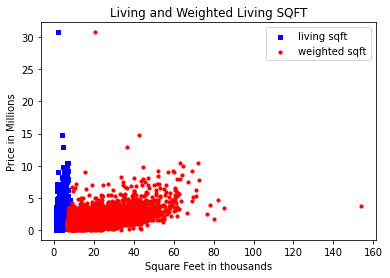

In [47]:
fig, ax = plt.subplots()

ax.scatter(df_living['living_sqft']/1000, df_living['price']/1000000, s=10, c='b', marker="s", label='living sqft')
ax.scatter(df_living['weighted_sqft']/1000, df_living['price']/1000000, s=10, c='r', marker="o", label='weighted sqft')
plt.legend(loc='upper right')
ax.ticklabel_format(style='plain')

# ax.axhline(y=0, color="black")
ax.set_xlabel("Square Feet in thousands")
ax.set_ylabel("Price in Millions")
ax.set_title("Living and Weighted Living SQFT")
plt.show();

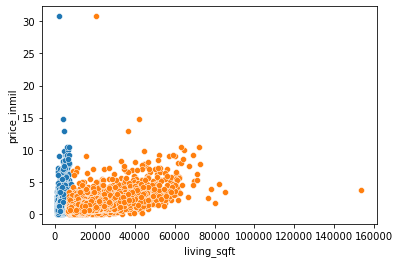

In [59]:
df_living['price_inmil'] = df_living['price']/1000000
# df_living['sqft_inthou'] = df_living['price']/1000000

sns.scatterplot(data = df_living, x = 'living_sqft', y = 'price_inmil')
sns.scatterplot(data = df_living, x = 'weighted_sqft', y = 'price_inmil')
ax.set_xlabel("Square feet")
ax.set_ylabel("Price in Millions")
ax.set_title("Living and Weighted Living SQFT");

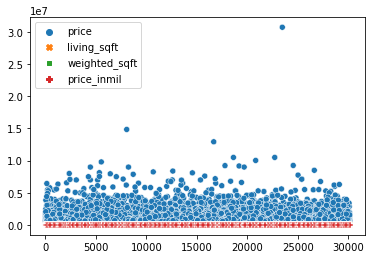

In [51]:
sns.scatterplot(data = df_living);